# Text Analytics

In this notebook, I will look at different techniques for getting insights from text data. After applying common preprocessing steps for text data, I will explore different tools for extracting information about the content of text documents. First, I will look at word frequencies and then detect word combinations that frequently appear together. Next, I will look at weighted word frequencies according to the tf-idf model. This model provides more informative statistics about key terms in a given document in the dataset compared to plain word frequencies. 

We will work with publicly available [press releases by the Swiss Federal Council](https://www.admin.ch/gov/en/start/documentation/media-releases/media-releases-federal-council.html?dyn_startDate=01.01.2015) about the Coronavirus 2019 epidemic. 

## A first look at the data

I will start by loading the data in a dataframe.

In [1]:
# Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Path to the data
PATH_DATA = os.path.join('./data/press_releases_covid19.csv')

# Load press releases
df = pd.read_csv(PATH_DATA)

print('Data shape: ',df.shape)

Data shape:  (61, 4)


Let's print a few samples from the data.

In [3]:
# Print a few samples

with pd.option_context('display.max_colwidth', 500):
    display(df.sample(3))

,title,url,pub_date,text
12,Coronavirus: Federal Council to ease further measures from 11 May,https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-78948.html,2020-04-29,"Bern, 29.04.2020 - At its meeting on 29 April, the Federal Council decided to further ease the measures introduced to protect the population against the coronavirus. From Monday, 11 May, shops, restaurants markets, museums and libraries will be allowed to reopen, classes can be held again in primary and lower secondary schools, and sports training sessions will be allowed. There will be a significant increase in scheduled public transport services. This year baccalaureate examination grades ..."
59,Coronavirus: Federal Council decides to maintain protective measures and calls on the public to get vaccinated,https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-84676.html,2021-08-11,"Bern, 11.08.2021 - At its meeting on 11 August, the Federal Council decided to maintain the measures that are still in place. However, this is designed to safeguard hospital capacity rather than protect the unvaccinated. A return to normality requires a massive increase in the number of people getting vaccinated. The current testing strategy, which is considered a key element of the response to the pandemic, is to be continued. From 1 October, tests for people without symptoms will no longer..."
24,"Coronavirus: Federal government to assume test costs, SwissCovid app to start on 25 June",https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-79584.html,2020-06-24,"Bern, 24.06.2020 - In order to be able to respond rapidly to a renewed increase in the number of cases, testing should be conducted as widely as is possible and appropriate. As of 25 June, the federal government will therefore be assuming the cost of all coronavirus tests. That was the decision taken by the Federal Council at its meeting on 24 June. It also adopted the Ordinance on the Proximity Tracing System for the Coronavirus. This will make it possible to for the SwissCovid app to be us..."


As we see, for each press release, we have the title, the URL, the publication date, and the text of the press release. Below, we drop the `url` column as we will not use it for the rest of our analysis.

In [4]:
# Remove 'url' column

df.drop(labels = ['url'],    # specify which columns to drop
        axis=1,              # drops labels from the columns
        inplace=True         # apply changes to the original df
       )

# Print data shape
print('Data shape: ',df.shape)

Data shape:  (61, 3)


In [5]:
# Show a few samples
df.sample(3)

,title,pub_date,text
25,Coronavirus: Emergency ordinance on COVID-19 c...,2020-07-01,"Bern, 01.07.2020 - During its meeting on 1 Jul..."
26,Coronavirus: Federal Council releases guarante...,2020-07-01,"Bern, 01.07.2020 - During its meeting on 1 Jul..."
43,Coronavirus: Federal Council extends and tight...,2021-01-13,"Bern, 13.01.2021 - Case numbers are stagnating..."


Our corpus has 61 documents. Below we check the data for duplicated entries and missing values.

In [6]:
# Check for duplicated entries

print('Found {} duplicated entries.'.format(df.duplicated().sum()))

Found 0 duplicated entries.


In [7]:
# Check for missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     61 non-null     object
 1   pub_date  61 non-null     object
 2   text      61 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


I used the `info` method, which prints information about data types, missing values, and memory usage. As we see, there aren't any missing values in the data. However, the data type of column `pub_date` is `object`. Below, I convert it to `datetime`.

In [8]:
# Convert pub_date to datetime dtype

df['pub_date'] = pd.to_datetime(df.pub_date)

# Check data types again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     61 non-null     object        
 1   pub_date  61 non-null     datetime64[ns]
 2   text      61 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.6+ KB


I converted the column `pub_date` to `datetime`. Below, I see that the earliest press release is from February 28, 2020, and the last one from August 18, 2021.

In [9]:
# Print earliest publication date

df['pub_date'].min()

Timestamp('2020-02-28 00:00:00')

In [10]:
# Print latest publication date

df['pub_date'].max()

Timestamp('2021-08-18 00:00:00')

## Text length

You may be wondering about the length of the press releases. Do they all use the same number of words or characters?

Let's look at the first press release.

In [11]:
print(df['text'][0])

Bern, 28.02.2020 - An extraordinary meeting of the Federal Council was held today, 28 February. In view of the current situation and the spread of the coronavirus, the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act. Large-scale events involving more than 1000 people are to be banned. The ban comes into immediate effect and will apply at least until 15 March. The Federal Council's top priority is to protect the population. It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act. This enables the Federal Council, in consultation with the cantons, to order measures that are normally the responsibility of the cantons.The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather. This ban on events comes into immediate effect and will apply at least until 15 March. The canton

I will start by splitting this document on whitespace using the split function.

In [12]:
# Split document on whitespace

print(df['text'][0].split())

['Bern,', '28.02.2020', '-', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today,', '28', 'February.', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus,', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned.', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March.', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population.', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'This', 'enables', 'the', 'Federal',

Splitting our document on whitespace has produced a list of tokens such as words, dates, numbers, and special characters. We can count the number of tokens in our document using the `len` function.

In [13]:
# Count the number of tokens in document
len(df['text'][0].split())

450

This particular document has 450 tokens (words, dates, etc.). What about the other press releases?

In a previous unit, we saw that we could use the `apply` function to apply a given function to all of the elements of a column in a dataframe. In the next cell, we use the `apply` function to count the number of tokens in each press release. 

In [14]:
df['text'].apply(lambda x: len(x.split()))

0      450
1     1982
2     1393
3      518
4      997
      ... 
56     983
57     105
58    2821
59    1675
60     534
Name: text, Length: 61, dtype: int64

This returns the number of tokens in each press release. The following plot shows the distribution of token counts in all of the press releases.

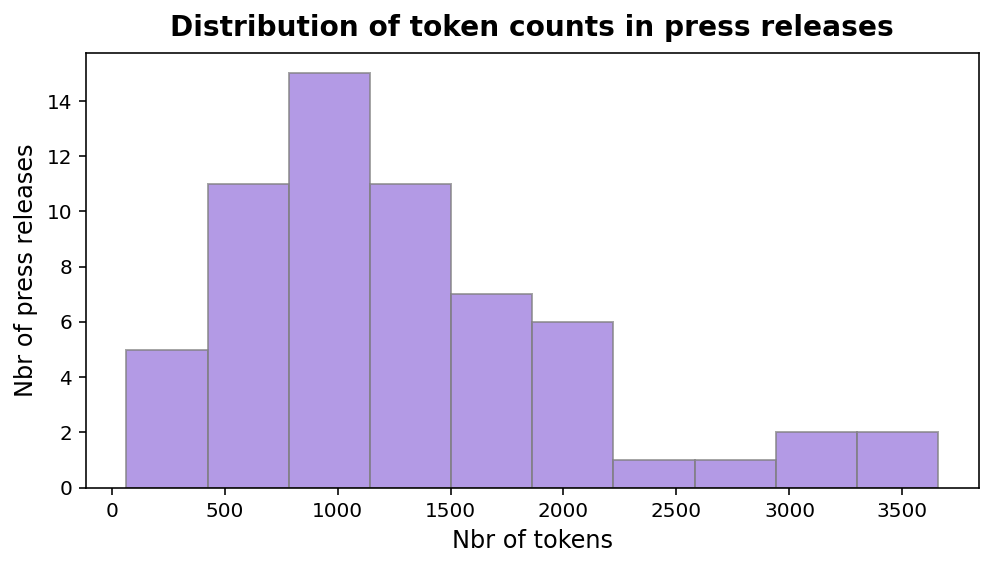

In [15]:
# Plot the number of tokens per press release

# Barplot and font specifications
barplot_specs = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
label_specs   = {"fontsize": 12}
title_specs   = {"fontsize": 14, "fontweight": "bold", "y": 1.01}

plt.figure(figsize=(8,4))

plt.hist(df['text'].apply(lambda x:len(x.split())), **barplot_specs)
plt.xlabel('Nbr of tokens', **label_specs)
plt.ylabel('Nbr of press releases',**label_specs)
plt.title('Distribution of token counts in press releases',**title_specs)
plt.show()

Below we use the `describe` method to get descriptive statistics for token counts in press releases.

In [16]:
df['text'].apply(lambda x: len(x.split())).describe()

count      61.000000
mean     1287.098361
std       800.633597
min        66.000000
25%       752.000000
50%      1132.000000
75%      1706.000000
max      3658.000000
Name: text, dtype: float64

The shortest press release has 66 tokens, and the longest has 3'658 tokens. The median number of tokens per press release is 1'132.

## Word frequencies

Now, we would like to know a bit more about what each press release is about. One way to answer this question would be to look at the most frequent tokens in each press release. Tokens that are mentioned several times in a text may reveal some information about the content of each press release.

Let's start with at an example of a press release from the data.

In [17]:
sample = df['text'][0]
print(sample)

Bern, 28.02.2020 - An extraordinary meeting of the Federal Council was held today, 28 February. In view of the current situation and the spread of the coronavirus, the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act. Large-scale events involving more than 1000 people are to be banned. The ban comes into immediate effect and will apply at least until 15 March. The Federal Council's top priority is to protect the population. It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act. This enables the Federal Council, in consultation with the cantons, to order measures that are normally the responsibility of the cantons.The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather. This ban on events comes into immediate effect and will apply at least until 15 March. The canton

We can start by splitting the document on whitespace and then count the instances of each token to find the most frequent one. However, there are some issues with this approach. Let's see why. 

In [18]:
# Split text on whitespace
print(sample.split()[0:150])

# Note: we show only the first 150 tokens

['Bern,', '28.02.2020', '-', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today,', '28', 'February.', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus,', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned.', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March.', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population.', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'This', 'enables', 'the', 'Federal',

This approach doesn't separate punctuation from adjacent words. For example, in the following tokens: `February.`, `March.`, `Act.`, etc., the period `.` wasn't separated from the preceding token. This is not great as it means `February.` and `February` won't be counted together.

Below, we replace characters such as commas, periods, parentheses and single hyphens (`-`) with whitespace, using regular expressions.

In [19]:
import re

# Replace punctuation marks (,.()) with whitespace
clean_sample = re.sub(r"[,.()]", # regex pattern
                      " ",       # replace with whitespace
                      sample     # string
                     )

# Replace single hyphens with whitespace
clean_sample = re.sub(r"\s-\s",      # regex pattern
                      " ",           # replace with whitespace
                      clean_sample   # string
                     )

# Print clean_sample
print(clean_sample)

Bern  28 02 2020 An extraordinary meeting of the Federal Council was held today  28 February  In view of the current situation and the spread of the coronavirus  the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act  Large-scale events involving more than 1000 people are to be banned  The ban comes into immediate effect and will apply at least until 15 March  The Federal Council's top priority is to protect the population  It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act  This enables the Federal Council  in consultation with the cantons  to order measures that are normally the responsibility of the cantons The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather  This ban on events comes into immediate effect and will apply at least until 15 March  The cantons 

Now we can go ahead and split the `clean_sample` on whitespace.

In [20]:
# Split clean_sample on whitespace
print(clean_sample.split()[0:150])

# Note: we show only the first 150 tokens

['Bern', '28', '02', '2020', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today', '28', 'February', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act', 'This', 'enables', 'the', 'Federal', 'Counci

We were able to separate punctuation marks from adjacent words and remove single hyphens. Let's go ahead and find the most common tokens in our text sample. We will use the `Counter` object from the `collections` module.

In [21]:
from collections import Counter

# Print top-25 most frequent tokens in clean_sample
Counter(clean_sample.split()).most_common(25)

[('the', 39),
 ('in', 20),
 ('to', 15),
 ('of', 12),
 ('Switzerland', 11),
 ('Federal', 10),
 ('and', 10),
 ('is', 10),
 ('The', 9),
 ('Council', 8),
 ('public', 8),
 ('events', 7),
 ('people', 7),
 ('at', 7),
 ('cantons', 6),
 ('or', 6),
 ('than', 5),
 ('1000', 5),
 ('are', 5),
 ('ban', 5),
 ('will', 5),
 ('situation', 4),
 ('It', 4),
 ('This', 4),
 ('with', 4)]

Here are a few observations: 
  
* The words "The" and "the" were counted separately. However, there is no advantage in tracking "The" and "the" separately.
* Words such as: "the", "in", "to", etc. are among the most common tokens. These words don't help us understand what a press release is about.

We will address both issues below.

### Case folding

It is common to convert documents to lowercase; instead of including all capitalized and lowercase versions of a word in the text (e.g., "The", and "The"), we keep only words in lowercase ("the").

In [22]:
# Case folding
processed_sample = clean_sample.lower()

print("Convert to lowercase: \n\n{}\n".format(processed_sample))

Convert to lowercase: 

bern  28 02 2020 an extraordinary meeting of the federal council was held today  28 february  in view of the current situation and the spread of the coronavirus  the federal council has categorised the situation in switzerland as ‘special’ in terms of the epidemics act  large-scale events involving more than 1000 people are to be banned  the ban comes into immediate effect and will apply at least until 15 march  the federal council's top priority is to protect the population  it is responding to the latest developments in the coronavirus epidemic and has categorised the situation in switzerland as ‘special' in terms of the epidemics act  this enables the federal council  in consultation with the cantons  to order measures that are normally the responsibility of the cantons the federal council is banning public and private events in switzerland at which more than 1000 people would gather  this ban on events comes into immediate effect and will apply at least unti

### Stop words

Words such as "the", "in", "to", are commonly referred to as *stop words* and are necessary for a sentence to make sense from a grammatical point of view. However, they are very "frequent" and usually "uninformative". Hence, in most cases, it is useful to remove them from text. 

Many libraries for working with text provide pre-compiled lists of stop words for several languages. We will use the list provided by the [NLTK library](https://www.nltk.org/).

In [23]:
# Load English stopwords from nltk

import nltk

nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords

stopwords_english = stopwords.words("english")

In [24]:
# Print stopwords

print("{} stopwords in NLTK's list.\n".format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

There are 179 words in NLTK's stop words list.

We can remove stop words from our document using list comprehensions.

In [25]:
# Use a list comprehension to remove stopwords from processed_sample

processed_sample_tokens = [tok for tok in processed_sample.split() if tok not in stopwords_english]
print(processed_sample_tokens)

['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal', 'council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread', 'coronavirus', 'federal', 'council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms', 'epidemics', 'act', 'large-scale', 'events', 'involving', '1000', 'people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'federal', "council's", 'top', 'priority', 'protect', 'population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms', 'epidemics', 'act', 'enables', 'federal', 'council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal', 'council', 'banning', 'public', 'private', 'events', 'switzerland', '1000', 'people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons', 'responsible', 'enforcing', 'ban'

So far, we removed punctuation marks, converted text to lowercase, and removed stop words. Let's recount words in our text sample. 

In [26]:
# Print top-25 most frequent tokens in processed_sample_tokens

Counter(processed_sample_tokens).most_common(25)

[('switzerland', 11),
 ('federal', 10),
 ('council', 8),
 ('public', 8),
 ('events', 7),
 ('people', 7),
 ('cantons', 6),
 ('1000', 5),
 ('ban', 5),
 ('situation', 4),
 ('private', 4),
 ('would', 4),
 ('gather', 4),
 ('event', 4),
 ('held', 3),
 ('spread', 3),
 ('coronavirus', 3),
 ('categorised', 3),
 ('terms', 3),
 ('epidemics', 3),
 ('act', 3),
 ('comes', 3),
 ('immediate', 3),
 ('effect', 3),
 ('apply', 3)]

It looks like our text cleaning was helpful. The topmost frequent tokens in this press release are now more "informative" about its content. It seems that this particular press release is about restricting the number of persons allowed to public and private events to reduce the spread of Covid-19.

At this point, it would be nice to combine all previous cleaning steps into a single function that we will call `preprocess_text`. This function takes a document, removes common punctuation marks, converts text to lowercase, removes stopwords, and splits on whitespace.

In [27]:
# Define preprocess_text function

def preprocess_text(text):
    
    '''
    This function preprocesses raw samples of text:
    - Converts to lowercase
    - Replaces common punctuation marks with whitespace
    - Removes stop words
    - Splits text on whitespace
    
    INPUT: 
    - text: "raw" text (string)
    
    OUTPUT:
    - processed_sample_tokens: list of tokens (list of strings)
    '''
    
    # Convert to lowercase
    clean_text = text.lower()
    
    # Replace common punctuation marks with whitespace
    clean_text = re.sub(r"[,.()]"," ", clean_text)
    
    # Replace single hyphens with whitespace
    clean_text = re.sub(r"\s-\s"," ", clean_text)
    
    # Remove stop words and split on whitespace
    processed_sample_tokens = [tok for tok in clean_text.split() if tok not in stopwords_english]
    
    return processed_sample_tokens

Let's test this function with an example. Below we sample a press release randomly from the dataset, using the `random` library.

In [28]:
# Sample a press release randomly from the data
import random
sample =  df.iloc[random.randint(0,len(df)-1),2]

print(preprocess_text(sample)[0:150])

# Note: we show only the first 150 tokens

['bern', '18', '11', '2020', 'meeting', '18', 'november', '2020', 'federal', 'council', 'decided', 'propose', 'winter', 'session', 'parliament', 'urgently', 'debate', 'ad', 'hoc', 'adjustments', 'covid-19', 'act', 'would', 'enable', 'swifter', 'reaction', 'ongoing', 'developments', 'second', 'wave', 'covid-19', 'pandemic', 'proposal', 'includes', 'expansion', 'hardship', 'support', 'programme', 'chf', '1', 'billion', 'total', 'increase', "confederation's", 'share', 'around', 'two', 'thirds', 'addition', 'short-time', 'working', 'compensation', 'payments', 'extended', 'sport', 'professional', 'semi-professional', 'clubs', 'able', 'receive', 'support', 'form', 'non-repayable', 'contributions', 'federal', 'council', 'considers', 'existing', 'package', 'measures', 'cushion', 'impact', 'pandemic', 'generally', 'sufficient', 'however', 'would', 'like', 'use', 'ad', 'hoc', 'adjustments', 'create', 'basis', 'better', 'reacting', 'developments', 'second', 'wave', 'federal', 'council', 'therefor

We can now use this function to process all press releases. This can be done either using list comprehensions or with the `apply` method.

In [29]:
# 1st alternative (using list comprehensions)

preprocessed_press_releases = [preprocess_text(doc) for doc in df['text']]

# Show an example of processed and tokenized text
print(preprocessed_press_releases[0])

['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal', 'council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread', 'coronavirus', 'federal', 'council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms', 'epidemics', 'act', 'large-scale', 'events', 'involving', '1000', 'people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'federal', "council's", 'top', 'priority', 'protect', 'population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms', 'epidemics', 'act', 'enables', 'federal', 'council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal', 'council', 'banning', 'public', 'private', 'events', 'switzerland', '1000', 'people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons', 'responsible', 'enforcing', 'ban'

In [30]:
# 2nd alternative (using the apply method)

df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x))

# Show an example of preprocessed and tokenized text
df.sample()

,title,pub_date,text,clean_text
32,Coronavirus: 2021 budget – subsequent notifica...,2020-09-25,"Bern, 25.09.2020 - The Federal Council and Par...","[bern, 25, 09, 2020, federal, council, parliam..."


### Collocations  

There is one more thing we can do with our texts. We can look for combinations of words that frequently appear together, such as *Federal Council*, *private event*, *Covid certificate*, etc. We often call these word combinations: *phrases* or *collocations*. These word combinations appear in texts more frequently than their constituent words appear individually.

We will use [Gensim's Phrases model](https://radimrehurek.com/gensim_3.8.3/models/phrases.html) to detect collocations in our corpus. `model.phrases` will identify the most common collocations and join the constituent tokens into a single token, using the "_" glue character. 

Examples:

$$\text{"Federal Council" → "Federal_Council"}$$

$$\text{"covid certificate" → "covid_certificate"}$$

$$\text{"press release" → "press_release"}$$  

In [31]:
# Import Gensim and Phrases

import gensim
from gensim.models import Phrases

We start by creating an instance of the `Phrases` model.

In [32]:
# Find common collocations in press releases

# Create an instance of the Phrases model
n_gram_model = Phrases(preprocessed_press_releases,       # Expected input format: list of tokenized texts
                       min_count=5,                       # Keeps only collocations with at least min_counts 
                       delimiter=b'_')                    # Glue character used to join collocation tokens

In the cell above, we set `min_count` to 5 to ignore any collocation appearing less than 5 times in the corpus. However, please note that this value is arbitrary. 

In the next step, we apply the `n_gram_model` model to the press releases texts.

In [33]:
# Apply Phrases to press releases

preprocessed_press_releases_collocations = [n_gram_model[doc] for doc in preprocessed_press_releases]

In [34]:
# Add processed press releases (with collocations) to dataframe

df['clean_text'] = preprocessed_press_releases_collocations

Let's print one example to see how it looks like.

In [35]:
print(preprocessed_press_releases_collocations[0])

['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal_council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread_coronavirus', 'federal_council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms_epidemics', 'act', 'large-scale_events', 'involving', '1000_people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', "federal_council's", 'top_priority', 'protect_population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms_epidemics', 'act', 'enables', 'federal_council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal_council', 'banning', 'public', 'private_events', 'switzerland', '1000_people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons_responsible', 'enforcing', 'ban', 'case', 'public', 'private_events', 'fewer_

As we see, the Phrases model has detected a few collocations in this press release, such as "federal_council", "private_events", "terms_epidemics", "cantonal_authorities", etc.

Below we count and plot the most frequent words in a randomly selected press release. This time we include collocations in the most common words.

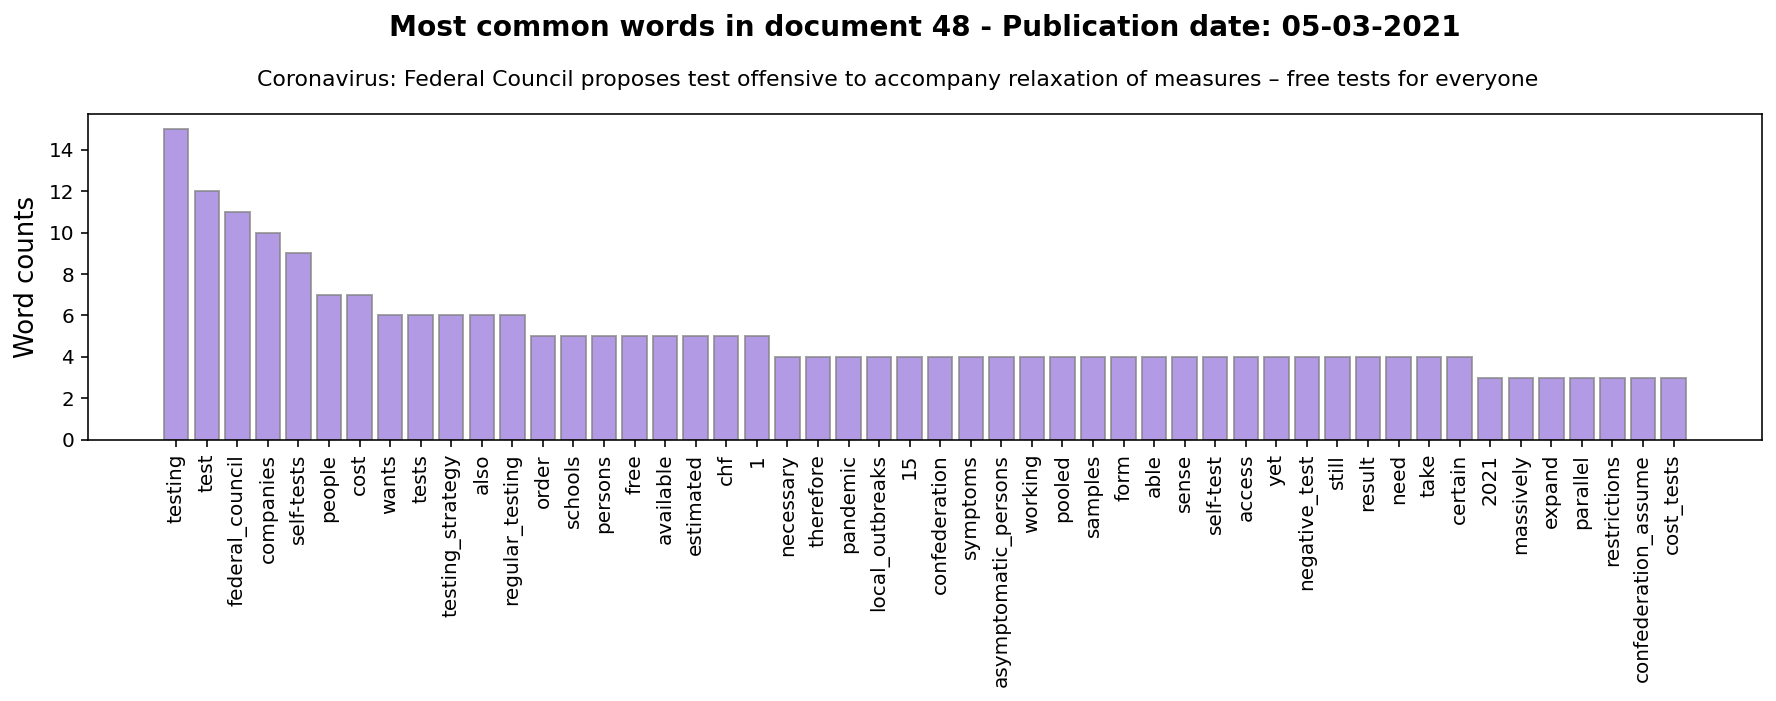

In [36]:
# Generates a random integer between 0 and len(df)
idx = random.randint(0,len(df))

# Find top-50 most common words
w = Counter(preprocessed_press_releases_collocations[idx]).most_common(50)

# Plots top words

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))
plt.bar(*zip(*w), **barplot_specs)
plt.title('Most common words in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Word counts', **label_specs)
plt.xticks(rotation=90)
plt.show()

Don't hesitate to run the previous cell several times and to compare your findings with the original text. Do the topmost frequent words help guess the "topic" of the press release?

In [37]:
# Print the original unprocessed text corresponding to the previous plot 
print('Printing document {}:\n'.format(idx))
print(df.iloc[idx,2])

Printing document 48:

Bern, 05.03.2021 - The Federal Council wants to massively expand testing in parallel to easing coronavirus restrictions. It is proposing that the Confederation should assume the cost of all tests to encourage more widespread testing. In order to improve the prevention and early detection of coronavirus outbreaks, companies and schools are to conduct regular testing. Employees at companies that test frequently can be exempted from the quarantine requirement for persons who have had contact with someone who has tested positive. In addition, the Federal Council wants to provide each member of the public with five free self-tests a month as soon as reliable tests are available. To ensure that everyone can be tested immediately, all tests in pharmacies and test centres will be free of charge, even for people without symptoms. The cost of expanding testing is estimated at over CHF 1 billion. The Federal Council will make a final decision after consulting the cantons on

### Tf-idf weighting model

So far, we have sorted words in documents by their frequencies. 

However, words that are very frequent across all documents in our corpus aren't necessarily "informative". For example, we are working with a corpus of official press releases from the Swiss Federal Council about the Coronavirus disease. We naturally expect tokens such as "Federal Council", "Switzerland", "Coronavirus", "Federal government", etc., to appear very often in all press releases. However, these tokens aren't necessarily conveying any "distinct information" about a press release's specific content, which may be about various topics such as vaccines, measures to contain the epidemic, testing, etc. We would like to give the words specific to a given press release higher weights so that we can discriminate it from other press releases in the same corpus.  

Therefore, we may want to:
  
* Diminish the importance of widespread words over the entire corpus of documents as they could shadow rarer yet more interesting words.
* Focus more on rare words across the corpus, as they could be more informative about the content of individual press releases.

This is known as *tf–idf* weighting model, where `tf` stands for term-frequency and `idf` stands for inverse document frequency and is a "measure" of a word's "rarity" in the corpus. The higher the idf, the "rarer" the word in the corpus. In other words, tf-idf model favors words, or terms, that are *frequent* in *few documents*.

Tf–idf is calculated as:

$$
{\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}
$$

where: 
  
- t : term, 
- d : document
- D : corpus.



The tf-idf model multiplies the usual frequency statistics `tf` by a weight factor `idf` in order to give a more informative score to each word. If you want to know more about the tf-idf model, please look at this [wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

Below, we will use the tf-idf weighting model from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html); a library that we will use very often in the following courses. 

We start by importing the tf-idf model from scikit-learn and creating an instance of it.

In [38]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the tf-idf model
tfidf = TfidfVectorizer()

Please note that the tf-idf model expects non-tokenized text; using it directly with `preprocessed_press_releases_collocations` would throw an error. This is why below we use the `join()` function to join lists of tokens into single strings.

In [39]:
# Join lists of tokens into single strings (for each press release)

X = [" ".join([w for w in doc]) for doc in preprocessed_press_releases_collocations]

Next, we call the `fit` method of `TfidfVectorizer()` on our text data.

In [40]:
# Fit model on text data
tfidf.fit(X);

A couple of things happen once we call the fit method of `TfidfVectorizer()` on our text data.

First, the `TfidfVectorizer` model tokenizes texts and builds the *vocabulary*. The vocabulary is the list of unique words in our corpus. We can check which words are part of the vocabulary using the `get_feature_names_out()` method.

In [41]:
# Show vocabulary
vocabulary = tfidf.get_feature_names_out()

# Print vocabulary length
print('Vocabulary length: {}\n'.format(len(vocabulary)))

# Show a few words from vocabulary
print('Show a few words from vocabulary:')
print(vocabulary[0:500:10])

Vocabulary length: 3947

Show a few words from vocabulary:
['000' '07' '11' '128' '16' '19_april' '1_july' '2021' '23' '27_may'
 '30_people' '480' '5_million' '72' '85' 'able' 'accept' 'accompanying'
 'act' 'acute' 'additional' 'adjustment' 'adolescents' 'advantages'
 'affects' 'age_16' 'ahead' 'airline' 'allfollowing' 'allowedfrom'
 'always' 'amounting' 'announced' 'anyone' 'appeared' 'appointment'
 'april_2020' 'armed' 'article' 'assessments' 'assume_cost'
 'asymptomatic_persons' 'attention' 'austrian' 'automatically'
 'aviation_industry' 'back' 'banned' 'basically' 'beds']


In our case, there are 3'947 words in our vocabulary. Once the texts are tokenized, and the vocabulary is established, tf-idf computes word frequencies `tf` and inverse document frequencies `idf`.

To transform each sample of text in our corpus into its tf-idf representation, we call the `transform()` method.

In [42]:
# Get tf-idf representation of text data
X_tfidf = tfidf.transform(X)
print(X_tfidf.shape)

(61, 3947)


The shape of X_tfidf is (61, 3947). Each row corresponds to a text document from the corpus and each column to a word in the vocabulary. 

We can check what `X_tfidf` looks like using the following code snippet.

In [43]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(),
                        columns=vocabulary)
df_tfidf.head()

,000,000_people,01,02,03,04,04_2020,05,05_2020,06,...,young_people,younger,youth,zealand,zero,zones,zoos,zoos_botanical,zoosin,zurich
0,0.000000,0.0,0.0,0.054617,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.014843,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.032799,0.0,0.0,0.000000,0.016399,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.035813,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.123561,0.0,0.0,0.000000,0.020593,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.064655,0.0,0.0,0.0,0.0,0.0


The tf-Idf model has converted each document to a list of tf-idf scores. Each row corresponds to a document from the corpus. For example, the first press release is represented by this list of numbers: [0, 0, 0, 0.054617, 0, 0, ...., 0, 0]. Note that tf-idf results in long vectors that are sparse (mostly filled with zeros).

### Top words according to tf-idf scores

Instead of looking at the topmost frequent words in each press release, we will focus on words with the highest tf-idf scores in each document. Remember, tf-idf favors words that are *frequent* in *few* press releases. We hope that this way, the importance of widespread words across all press releases (such as "Federal Council", etc.) will be diminished, letting us focus on other more informative words about the content of individual press releases. 

Below we plot the top 50 words according to the tf-idf scores.

In [44]:
# Set number of top words to plot
N = 50

print('Printing top words according to tf-idf for document {}.'.format(idx))

Printing top words according to tf-idf for document 48.


In [45]:
# Sort indexes according to tf-idf scores for document idx

index_sorted = np.argsort(df_tfidf.iloc[idx,:])[::-1]  # descending order

# Print sorted indexes according to tf-idf
index_sorted.values

array([3579, 3194, 3588, ..., 2581, 2580,    0])

In [46]:
# Sort words in vocabulary according to tf-idf

features_sorted = np.array(vocabulary)[index_sorted][0:N]

# Print top words according to tf-idf scores
print(features_sorted)

['test' 'self' 'tests' 'testing' 'companies' 'regular_testing' 'estimated'
 'cost' 'testing_strategy' 'sense' 'samples' 'wants' 'pooled'
 'asymptomatic_persons' 'local_outbreaks' 'negative_test' 'frequently'
 'massively' 'expanding' 'persons' 'symptoms' 'schools' 'free' 'detection'
 'form' 'yet' 'parallel' 'reliable' 'available' 'federal_council'
 'working' 'confederation_assume' 'expand' 'prevention' 'cost_tests'
 'people' 'chf' 'need' 'access' 'result' 'everyone' '15' 'immediately'
 'order' 'economic_life' 'billionthe' 'irresponsible' 'snapshot' 'sample'
 'everyonesuccess']


In [47]:
# Sort tf-idf scores (descending order)

tfidf_weights_sorted = df_tfidf.iloc[idx,:][index_sorted][0:N]
print(tfidf_weights_sorted)

test                    0.301162
self                    0.299038
tests                   0.255906
testing                 0.243577
companies               0.176705
regular_testing         0.154796
estimated               0.138916
cost                    0.136359
testing_strategy        0.131639
sense                   0.122319
samples                 0.122319
wants                   0.116880
pooled                  0.111133
asymptomatic_persons    0.111133
local_outbreaks         0.103197
negative_test           0.097041
frequently              0.091739
massively               0.091739
expanding               0.091739
persons                 0.090231
symptoms                0.087759
schools                 0.085797
free                    0.085797
detection               0.083350
form                    0.077920
yet                     0.077920
parallel                0.077398
reliable                0.077398
available               0.077131
federal_council         0.075863
working   

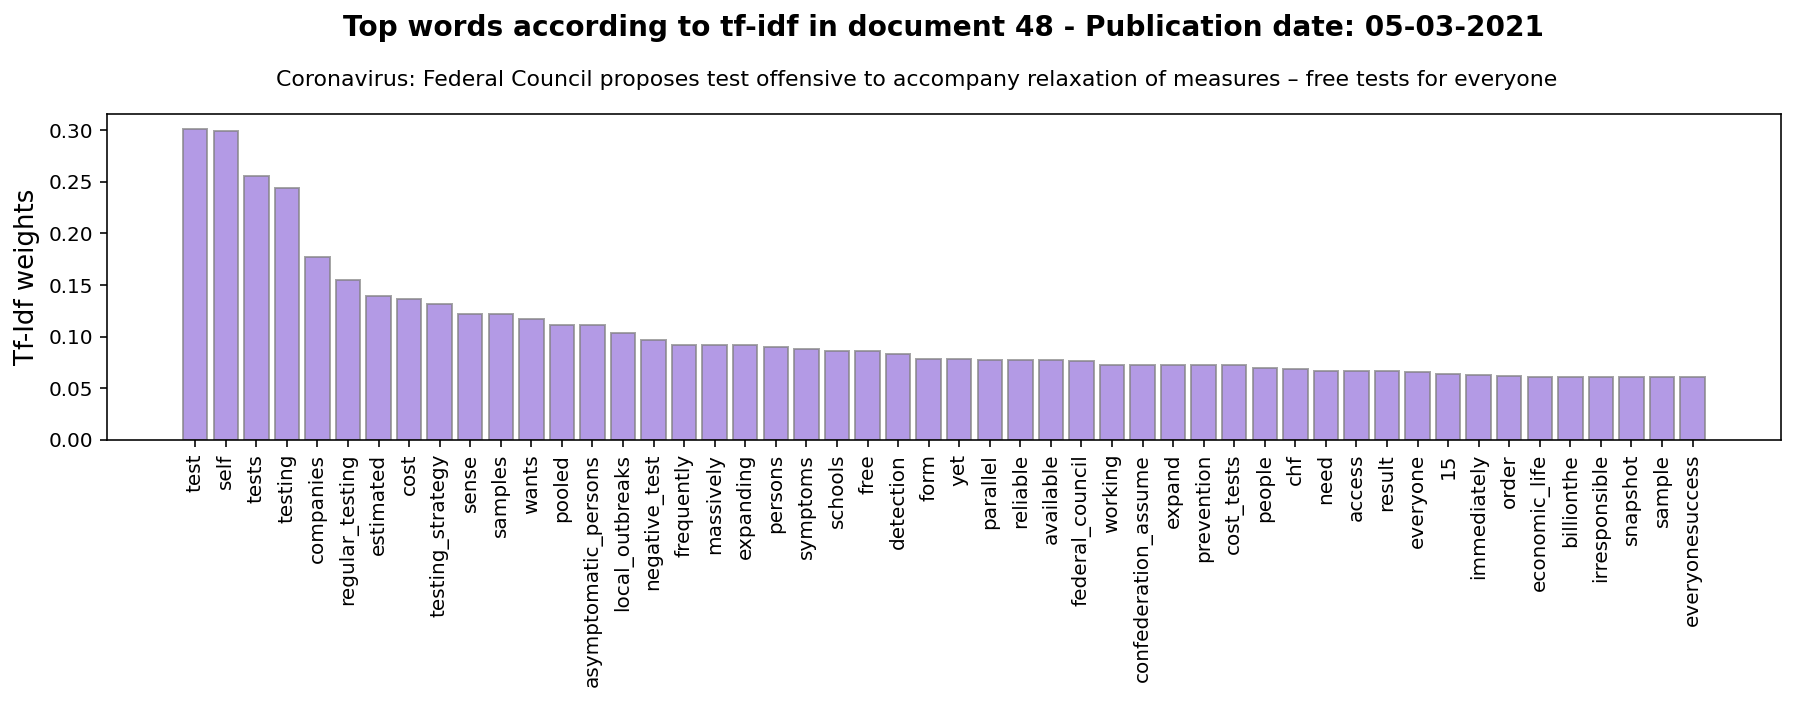

In [48]:
# Plots top words according to tf-idf scores

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))

plt.bar(x = features_sorted,
        height=tfidf_weights_sorted,
        **barplot_specs)

plt.title('Top words according to tf-idf in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Tf-Idf weights', **label_specs)
plt.xticks(rotation=90)
plt.show()

Don't hesitate to compare this approach with the topmost frequent words for the same press release. Hopefully, diminishing the importance of widespread words across all documents has helped to focus on rare words that are more informative about the content of individual press releases. You can experiment with both techniques to see which works best in your particular case.